In [89]:
import import_ipynb
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pylab
from scipy.stats import zscore, norm, kurtosis, shapiro, skew
import sklearn

import twint 
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [90]:
# top 25 tickers
tickers = ['msft', 'amzn', 'googl', 'goog', 'fb', 'nvda', 'brk.b', 'jpm', 'hd', 'jnj', 'unh', 'pg', 'bac', 'v',
             'abde', 'nflx', 'crm', 'pfe', 'dis', 'ma', 'xom', 'tmo', 'cost']

In [91]:
def stockdata(ticker, timedelta = 9999):
    data = yf.Ticker(ticker).history(start = dt.date.today()-dt.timedelta(days=timedelta))
    data['Stock_Return'] = ((data['Close']/data['Close'].shift())-1)
    data = data.drop(['Dividends','Stock Splits'], axis = 1)
    data = data.rename(columns={'Close': 'Stock_Close', 'Open': 'Stock_Open', 'Low': 'Stock_Low', 
                                  'Volume': 'Stock_Volume', 'High': 'Stock_High'})
    return data

def marketdata(timescale=9999):
    SP500 = yf.Ticker("^GSPC").history(start = dt.date.today()-dt.timedelta(days = timescale))
    SP500.dropna(inplace=True)  
    SP500 = SP500.drop(['Dividends','Stock Splits'], axis = 1)
    SP500['Market_Return'] = SP500['Close'].pct_change()
    SP500 = SP500.rename(columns={'Close': 'Market_Close', 'Open': 'Market_Open', 'Low': 'Market_Low', 
                                  'Volume': 'Market_Volume', 'High': 'Market_High'})

    #SP500['Weekly_Return'] = SP500.resample('W').mean()['Close'].pct_change().ffill()
    #SP500['Monthly_Return'] = SP500.resample('M').mean()['Close'].pct_change()
    return SP500

In [92]:
stock = stockdata("MSFT")
market = marketdata(365)

# Which factors affect the stock prices

## Variable Identification
- Predictors: Sentiment Analyis of Stocks and Market, Mean Reversion Scores, Insider Trading, Institutional Trading, Analyst Ratings, Comparative Metrics (Market/Sector/Industry Performance), Historical Performance on Financial Statements,
- Target Variable: Stock Price, Stock Volume
- Data Types: All numerical
- Variable Category:  --- All continuous

## Sentiment Analysis of Market 
- Unsupervised Analysis: Identify any clustering in semantic analysis and whether this is reproducible
- Supervised Analysis:How this trends with stock prices for supervised analysis

In [93]:
# Training data: 5 years of data
# Test data: Last year of data

In [94]:
class dfTweets:
    def __init__(self, ticker, source = None, likes=100, days=365):
        self.ticker = ticker
        self.likes = likes
        self.days = days
        self.query = "(${ticker} OR {ticker})".format(ticker = ticker)

    def stockTweets(self):
        c = twint.Config()
        c.Search = self.query
        c.Lang = 'en'
        c.Hide_output = True
        c.Pandas = True
        c.Min_likes = self.likes
        c.Since = str(dt.date.today()-dt.timedelta(days = self.days))
        c.Until = str(dt.date.today())
        twint.run.Search(c)
        data = twint.storage.panda.Tweets_df
    
        data['dates'] = data.date.astype({'date': 'datetime64[ns]'}) # converts date to dt.date type
        data = data[["dates", "tweet", "nlikes"]]
        
        return data

    def verifiedTweets(self):
        c = twint.Config()
        c.Search = self.query + " filter:verified"
        c.Lang = 'en'
        c.Hide_output = True
        c.Pandas = True
        c.Min_likes = self.likes
        c.Since = str(dt.date.today()-dt.timedelta(days = self.days))
        c.Until = str(dt.date.today())
        twint.run.Search(c)
        data = twint.storage.panda.Tweets_df
        
        data['dates'] = data.date.astype({'date': 'datetime64[ns]'}) # converts date to dt.date type
        data = data[["dates", "tweet", "nlikes"]]
        
        return data

    def generalTweets(self):
        if self.ticker == "spx":
            query = '(sp500 OR "stock market" OR "federal reserve" OR market AND fed)'
        else:
            query = "({ticker} OR #{ticker})".format(ticker = self.ticker)
        c = twint.Config()
        c.Search = self.query
        c.Lang = 'en'
        c.Hide_output = True
        c.Pandas = True
        c.Min_likes = self.likes
        c.Since = str(dt.date.today()-dt.timedelta(days = self.days))
        c.Until = str(dt.date.today())
        twint.run.Search(c)
        data = twint.storage.panda.Tweets_df

        data['dates'] = data.date.astype({'date': 'datetime64[ns]'}) # converts date to dt.date type
        data = data[["dates", "tweet", "nlikes"]]
        
        return data

<code> 
# Choosing number of likes: based on len(dataframe) returned
# need over 1000 data points for the analysis to be accurate

for i in range(50,5000,100):
    print(i)
    data = dfTweets("spx",likes = i, days = 365).stockTweets()
    print(len(data))
    print(data.dates[0])
    print(data.dates[len(data)-1]) 
    # 100/150 likes for stockTweets

for i in range(50,5000,50):
    print(i)
    data = dfTweets("SP500",likes = i, days = 365).generalTweets()
    print(len(data))
    print(data.dates[0])
    print(data.dates[len(data)-1])
    # 100 likes for generalTweets
    
for i in range(20,100,20):
    print(i)
    data = dfTweets("spx",likes = i, days = 365).verifiedTweets()
    print(len(data))
    print(data.dates[0])
    print(data.dates[len(data)-1])
    # 20 likes for verifiedTweets

# Improving Sentiment Analysis

In [95]:
stock_tweets = dfTweets("spx",likes = 100).stockTweets()
general_tweets = dfTweets('spx', likes = 100).generalTweets()
verified_tweets = dfTweets("spx", likes = 20).verifiedTweets()

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [96]:
def SentimentAnalysis(df):
    analyzer = SentimentIntensityAnalyzer()
    scores = df['tweet'].apply(analyzer.polarity_scores).tolist()  
    df_scores = pd.DataFrame(scores)
    df_scores = df.join(df_scores, rsuffix='_right')        
    
    return df_scores

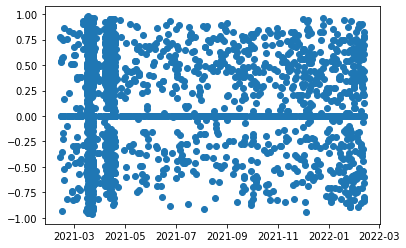

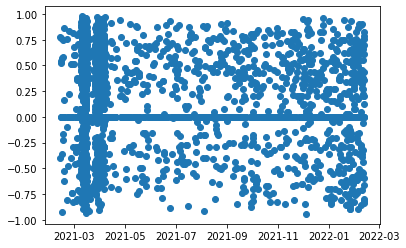

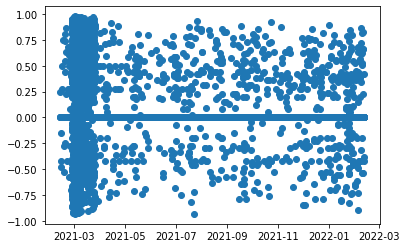

In [97]:
stock_sentiment = SentimentAnalysis(stock_tweets)
general_sentiment = SentimentAnalysis(general_tweets)
verified_sentiment = SentimentAnalysis(verified_tweets)

plt.scatter(x=stock_sentiment.dates, y = stock_sentiment['compound'])
plt.show()

plt.scatter(x=general_sentiment.dates, y = general_sentiment['compound'])
plt.show()

plt.scatter(x=verified_sentiment.dates, y = verified_sentiment['compound'])
plt.show()

### Inferences
- Large majority of data lies around 0. This is due to the sentiment analysis marking most headlines as neutral. 
- Some clustering is visible in the data set.

### Initial Problems:
- Large amounts of data centered around neutrality(0) and these are redundant predictors which will not aid in the prediction of data, thus they should be removed. 
- There are multiple different tweets for each day, with different scores. For data analyis, we need a single sentiment score per day. We can acquire this from getting the mean sentiment of each day.

## Data Cleaning

In [98]:
# Solution
def SentimentAnalysis(df):
    # Sentiment Analysis
    analyzer = SentimentIntensityAnalyzer()
    scores = df['tweet'].apply(analyzer.polarity_scores).tolist()  
    df_scores = pd.DataFrame(scores)
    df_scores = df.join(df_scores, rsuffix='_right')    
    # removing neutral scores as they reduce sentiment mean
    df_scores = df_scores[df_scores['compound'] != 0]
    
    # gets the mean sentiment score of that days tweets
    df_scores = df_scores.groupby(df_scores.dates.dt.date).mean()     
    
    return df_scores

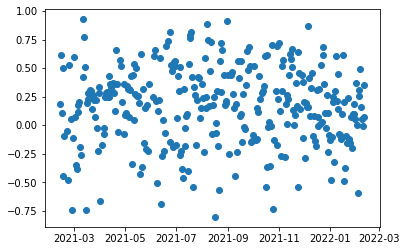

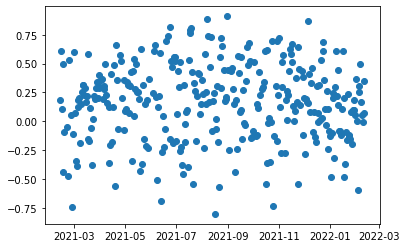

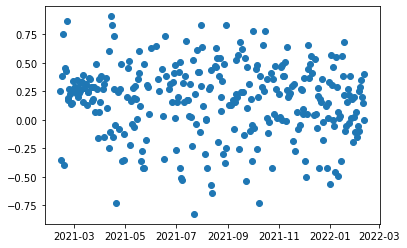

In [99]:
# Sentiment data
stock_sentiment = SentimentAnalysis(stock_tweets)
general_sentiment = SentimentAnalysis(general_tweets)
verified_sentiment = SentimentAnalysis(verified_tweets)

plt.scatter(x=stock_sentiment.index, y = stock_sentiment['compound'])
plt.show()

plt.scatter(x=general_sentiment.index, y = general_sentiment['compound'])
plt.show()

plt.scatter(x=verified_sentiment.index, y = verified_sentiment['compound'])
plt.show()

### Changes
- Neutral observations were removed as they provided no insight to this data analysis

### Inferences
- Data does not take likes into account currently and this can be used to magnify how popular certain sentiments are



In [100]:
# Solution
def SentimentAnalysis(df):
    # Sentiment Analysis
    analyzer = SentimentIntensityAnalyzer()
    scores = df['tweet'].apply(analyzer.polarity_scores).tolist()  
    df_scores = pd.DataFrame(scores)
    df_scores = df.join(df_scores, rsuffix='_right')    
    df_scores = df_scores[df_scores['compound'] != 0] # removing neutral scores as they provide no insight  and reduce sentiment mean
    df_scores['scores'] = df_scores['compound']*df_scores['nlikes'] # factor in no of likes
    
    # gets the mean sentiment score of that days tweets
    df_scores = df_scores.groupby(df_scores.dates.dt.date).mean()     
    
    return df_scores

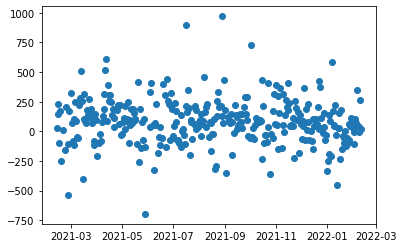

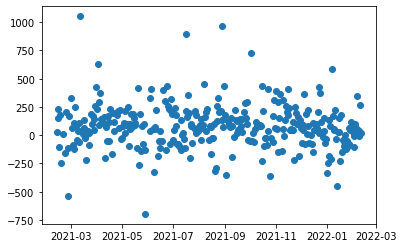

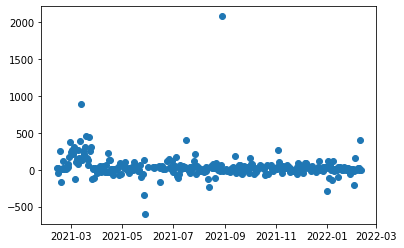

In [101]:
# Sentiment data
stock_sentiment = SentimentAnalysis(stock_tweets)
general_sentiment = SentimentAnalysis(general_tweets)
verified_sentiment = SentimentAnalysis(verified_tweets)

plt.scatter(x=stock_sentiment.index, y = stock_sentiment['scores'])
plt.show()

plt.scatter(x=general_sentiment.index, y = general_sentiment['scores'])
plt.show()

plt.scatter(x=verified_sentiment.index, y = verified_sentiment['scores'])
plt.show()

# Changes
- Likes were factored into the analysis by simply multiplying them by the sentiment score of their tweets

### Inferences
- There are high leverage points and outliers
- - These tweets may provide special insight and can be more indicative of the market sentiment
- Most of the data is centralised around 0 and have roughly a similar variance over time.

### Issues
-  The distribution of the data makes it much harder to identify clusters between different sentiment scores.
- - As the mean of the data is centered around 0.0, and homoskedasticity is being observed(constant variance), a gaussian model may be suitable for this problem. 
- - Feature scaling is required for clustering methods to be effective.
- - Moreover, data is no longer -1 to 1 in scale so it is much harder to interpret whether a score is positive or negative

# Univariate Analysis 

count    326.000000
mean       0.169873
std        0.339955
min       -0.802000
25%       -0.073363
50%        0.201340
75%        0.416258
max        0.928400
Name: compound, dtype: float64


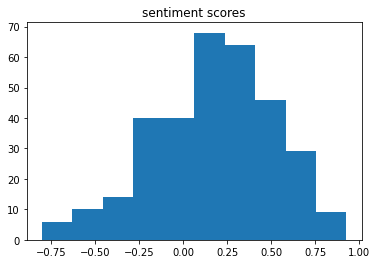

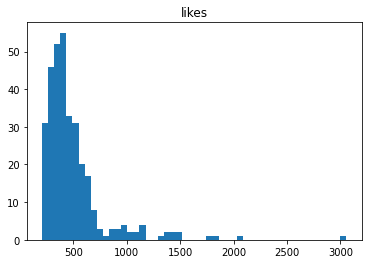

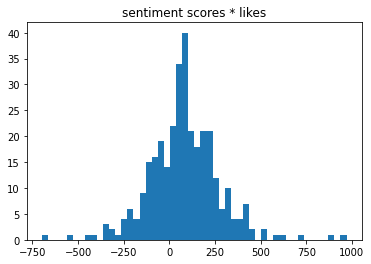

In [102]:
# Understanding the data - Compound and Scores
print(stock_sentiment['compound'].describe())

# Data Visualisation - Histogram
plt.hist(stock_sentiment['compound']) # sentiment score
plt.title("sentiment scores")
plt.show()

plt.hist(stock_sentiment['nlikes'], bins = 50) # likes
plt.title("likes")
plt.show()

plt.hist(stock_sentiment['scores'], bins = 50)
plt.title("sentiment scores * likes")
plt.show()

### Compound/Scores distribution
- Median/Mean is roughly equivalent, however there are some outliers which are evident in this bottom . 
- Outliers should be investigated
- Normal distribution test should be conducted to see if this is a suitable model

## Outliers

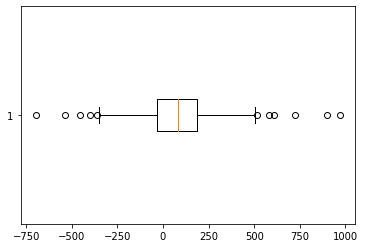

11

In [103]:
# It is apparent that there are many outliers in likles. A boxplot will be helpful in identifying these. 
# Boxplot
plt.boxplot(stock_sentiment['scores'], vert = False)
plt.show()

# Getting outliers
def detect_outliers(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

nlikes_outliers = detect_outliers(stock_sentiment['scores'])
len(nlikes_outliers)

### Handling Outliers
There is a 28 outliers in likes. There are multiple ways to tackle outliers but I shall explain below why they should not be used here:
1) Removing outliers 
- This is the worst option by far since these outliers offer essential insight on how popular certain sentiment scores are

2) Quantile based flooring and capping
- This is the best option as it will still be representative of how popular the tweet is yet allow for useful data analytics. However, the extremeness of certain tweets can offer signficant insight and should not be capped. 

3) Apply a median value to the value of these outliers.
- Ineffective as it mutes these tweets and makes them ineffective essentially, similar to the first option

Overall, this has led me to include these outliers in my dataset.


## Normality test

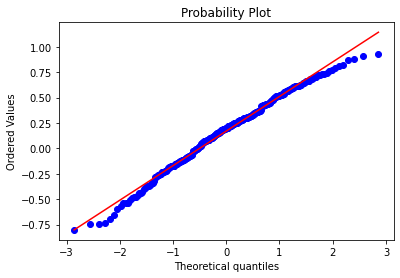

Shapiro-wilk test:0.0129608865827322


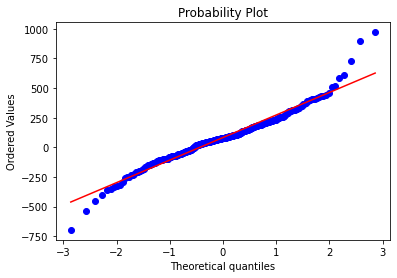

kurtosis is 5.965411620907535
Shapiro-wilk test:2.578397300112556e-07


In [104]:
# Testing different standardization techniques for best results  

# normality test for sentiment scores
scipy.stats.probplot(stock_sentiment['compound'], dist="norm", plot=pylab)
pylab.show()

# Shapiro-wilk test
stat, p = shapiro(stock_sentiment['compound'])
print("Shapiro-wilk test:" + str(p))

# normality test for sentiment scores
scipy.stats.probplot(stock_sentiment['scores'], dist="norm", plot=pylab)
pylab.show()

# Kurtosis
print("kurtosis is " + str(kurtosis(stock_sentiment['scores'], fisher = False))) # Using the pearson definition

# Shapiro-wilk test
stat, p = shapiro(stock_sentiment['scores'])
print("Shapiro-wilk test:" + str(p))

### Shapiro-wilk Test
- The shapiro-wilk p-value for compound (sentiment analysis) is statistically significant, but barely. This implies it is normal but there may be some issues with the distribution. 
- On the other hand, the shapiro test for scores (sentiment analyis multiplied by number of likes) is not normal, as it p-value is not statistically significant.

### Kurtosis and Skewness of Scores
- From the QQ plot, it is evident that the data is heavy-tailed.
- - Moreover, the kurtosis of the datasets is 6 which is much larger than 3 indicating heavy tails.
- This is due to the feature "likes" as likes has a very heavy-tailed distribution. Thus an appropriate transformation should be made to make the data more normally distributed.

## Transformations

C:\Users\nurul\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


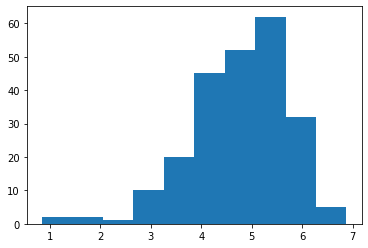

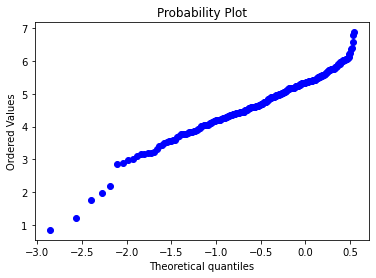

kurtosis is nan
shapiro test p-value is 1.0


C:\Users\nurul\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [105]:
# Two possible log transformation are:
# 1) Transform the scores using log
transformation1 = np.log(stock_sentiment['scores'])
plt.hist(transformation1)# logs
plt.show()

# QQ plot
scipy.stats.probplot(transformation1, dist="norm", plot=pylab)
pylab.show()

# Kurtosis
print("kurtosis is " + str(kurtosis(np.log(stock_sentiment['scores']), fisher = False))) # Using the fisher definition

# Shapiro test
stat, p = shapiro(transformation1)
print("shapiro test p-value is " + str(p))

# ALthough the shapiro wilk score is high, the data is still heavy tailed on the lower end as shown by the qq plot
# This is due to using log on negative values which returns nan values, hence why kurtosis does NOT work.

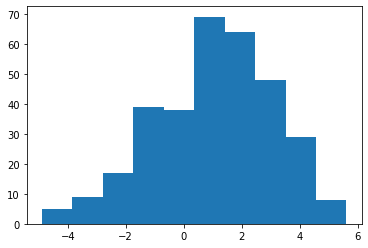

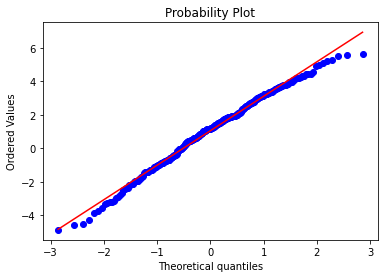

kurtosis is 2.852016331778139
skew is -0.31205389601126826
shapiro test p-value is 0.03130323439836502


In [106]:
# 2) Transform likes using log transfomation
log_transformation = stock_sentiment['compound']*np.log(stock_sentiment['nlikes'])


# It is clear that using the log transformation is the most superior and produces a normal distribution
plt.hist(log_transformation)# logs
plt.show()

# QQ plot
scipy.stats.probplot(log_transformation, dist="norm", plot=pylab)
pylab.show()

# Kurtosis
print("kurtosis is " + str(kurtosis(log_transformation, fisher = False))) # Using the fisher definition

# Kurtosis
print("skew is " + str(skew(log_transformation))) # Using the fisher definition

# Shapiro test
stat, p = shapiro(log_transformation)
print("shapiro test p-value is " + str(p))

## Test Results: Second Transformation  is Superior
- 1) Much improved qq plot, with light tails on both side. 
- 2) Statistically signifant p-value produed by shapiro-wilk test
- 3) Kurtosis is close to 3.
- 4) Skew is close to 0.

Therefore, the second transfomation is pasts the normality test and is best


### Sentiment Analysis using Transformation

In [124]:
# Solution
def SentimentAnalysis(df):
    # Sentiment Analysis
    analyzer = SentimentIntensityAnalyzer()
    scores = df['tweet'].apply(analyzer.polarity_scores).tolist()  
    df_scores = pd.DataFrame(scores)
    df_scores = df.join(df_scores, rsuffix='_right')    
    df_scores = df_scores[df_scores['compound'] != 0] # removing neutral scores as they provide no insight  and reduce sentiment mean
    
    # log transformation
    df_scores['scores'] = df_scores['compound']*np.log(df_scores['nlikes'])
    
    # applying normal distribution
    standard_scores = (df_scores['scores']-df_scores['scores'].mean())/df_scores['scores'].std()
    df_scores['scores'] = standard_scores.apply(lambda x: norm.cdf(x) if x>0 else -(1-norm.cdf(x)))
    
    # gets the mean sentiment score of that days tweets
    df_scores = df_scores.groupby(df_scores.dates.dt.date).mean()     
    
    return df_scores

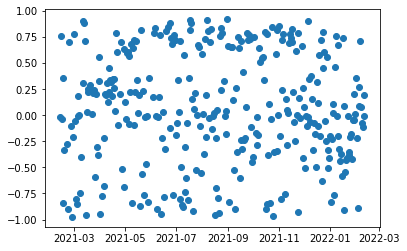

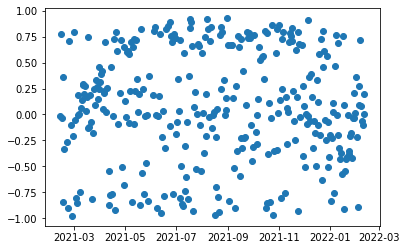

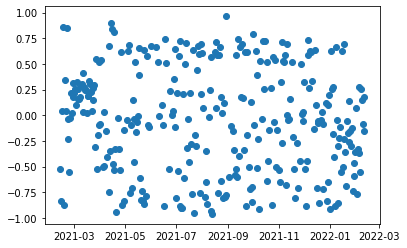

In [127]:
stock_sentiment = SentimentAnalysis(stock_tweets)
general_sentiment = SentimentAnalysis(general_tweets)
verified_sentiment = SentimentAnalysis(verified_tweets)

plt.scatter(x=stock_sentiment.index, y = stock_sentiment['scores'])
plt.show()

plt.scatter(x=general_sentiment.index, y = general_sentiment['scores'])
plt.show()

plt.scatter(x=verified_sentiment.index, y = verified_sentiment['scores'])
plt.show()

## Bivariate Analysis


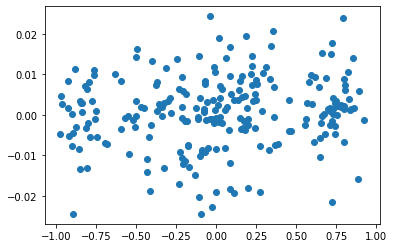

,nlikes,neg,neu,pos,compound,scores,Market_Open,Market_High,Market_Low,Market_Close,Market_Volume,Market_Return
nlikes,1.000000,-0.071069,0.107065,-0.054024,0.004362,-0.050682,-0.060854,-0.057727,-0.057504,-0.053575,0.083246,0.080365
neg,-0.071069,1.000000,-0.422561,-0.358057,-0.738252,-0.664792,0.077412,0.077950,0.063749,0.066349,-0.037080,-0.103731
neu,0.107065,-0.422561,1.000000,-0.694939,-0.026789,-0.066470,-0.004680,-0.009571,0.000681,-0.003812,0.032228,0.002808
pos,-0.054024,-0.358057,-0.694939,1.000000,0.613228,0.595755,-0.056502,-0.051876,-0.051183,-0.048584,-0.003930,0.079608
compound,0.004362,-0.738252,-0.026789,0.613228,1.000000,0.939810,0.006585,0.005536,0.024220,0.018941,-0.095572,0.145882
scores,-0.050682,-0.664792,-0.066470,0.595755,0.939810,1.000000,-0.002747,-0.003473,0.012119,0.008259,-0.073917,0.131773
Market_Open,-0.060854,0.077412,-0.004680,-0.056502,0.006585,-0.002747,1.000000,0.997165,0.994903,0.991698,-0.661575,-0.084445
Market_High,-0.057727,0.077950,-0.009571,-0.051876,0.005536,-0.003473,0.997165,1.000000,0.993269,0.995090,-0.657644,-0.034194
Market_Low,-0.057504,0.063749,0.000681,-0.051183,0.024220,0.012119,0.994903,0.993269,1.000000,0.995381,-0.693584,-0.013493
Market_Close,-0.053575,0.066349,-0.003812,-0.048584,0.018941,0.008259,0.991698,0.995090,0.995381,1.000000,-0.681714,0.035543


In [128]:
data = general_sentiment.join(market, how='inner')

plt.scatter(data.scores, data.Market_Return)
plt.
plt.show()

data.corr()

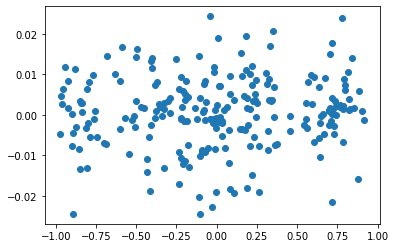

,nlikes,neg,neu,pos,compound,scores,Market_Open,Market_High,Market_Low,Market_Close,Market_Volume,Market_Return
nlikes,1.000000,-0.071024,0.067991,-0.010253,0.011872,-0.041477,-0.063763,-0.062555,-0.059512,-0.058228,0.064418,0.064319
neg,-0.071024,1.000000,-0.438437,-0.388968,-0.754933,-0.700066,0.030533,0.032847,0.020270,0.025223,-0.024566,-0.048823
neu,0.067991,-0.438437,1.000000,-0.657443,-0.018917,-0.035050,0.011171,0.008769,0.014719,0.011497,0.027297,-0.002880
pos,-0.010253,-0.388968,-0.657443,1.000000,0.652246,0.622707,-0.036956,-0.036423,-0.031988,-0.032804,-0.007567,0.044057
compound,0.011872,-0.754933,-0.018917,0.652246,1.000000,0.937097,0.010624,0.007425,0.026752,0.019041,-0.096272,0.099703
scores,-0.041477,-0.700066,-0.035050,0.622707,0.937097,1.000000,-0.005106,-0.010178,0.007597,0.000365,-0.081196,0.075900
Market_Open,-0.063763,0.030533,0.011171,-0.036956,0.010624,-0.005106,1.000000,0.997160,0.994904,0.991655,-0.658200,-0.074294
Market_High,-0.062555,0.032847,0.008769,-0.036423,0.007425,-0.010178,0.997160,1.000000,0.993268,0.995050,-0.654278,-0.024023
Market_Low,-0.059512,0.020270,0.014719,-0.031988,0.026752,0.007597,0.994904,0.993268,1.000000,0.995365,-0.690794,-0.003364
Market_Close,-0.058228,0.025223,0.011497,-0.032804,0.019041,0.000365,0.991655,0.995050,0.995365,1.000000,-0.678572,0.046079


In [129]:
data = stock_sentiment.join(market, how='inner')

plt.scatter(data.scores, data.Market_Return)
plt.show()

data.corr()

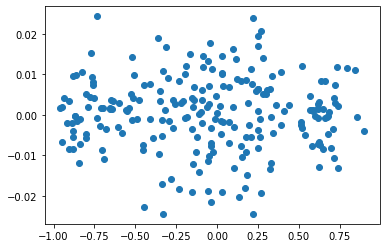

,nlikes,neg,neu,pos,compound,scores,Market_Open,Market_High,Market_Low,Market_Close,Market_Volume,Market_Return
nlikes,1.000000,0.006312,-0.080850,0.072924,0.027501,0.097495,-0.418529,-0.415349,-0.416287,-0.415965,0.447898,0.066546
neg,0.006312,1.000000,-0.384520,-0.447254,-0.773211,-0.669756,0.046672,0.046791,0.045386,0.050725,-0.103677,0.017255
neu,-0.080850,-0.384520,1.000000,-0.653661,-0.037357,-0.096242,0.016195,0.012848,0.010904,0.009780,0.016765,-0.069327
pos,0.072924,-0.447254,-0.653661,1.000000,0.669993,0.642047,-0.053680,-0.050539,-0.047489,-0.050793,0.068499,0.052671
compound,0.027501,-0.773211,-0.037357,0.669993,1.000000,0.899186,-0.097880,-0.098183,-0.091846,-0.101195,0.135506,-0.004853
scores,0.097495,-0.669756,-0.096242,0.642047,0.899186,1.000000,-0.112420,-0.113994,-0.110015,-0.118285,0.162927,-0.015299
Market_Open,-0.418529,0.046672,0.016195,-0.053680,-0.097880,-0.112420,1.000000,0.997198,0.995017,0.991648,-0.676390,-0.077295
Market_High,-0.415349,0.046791,0.012848,-0.050539,-0.098183,-0.113994,0.997198,1.000000,0.993558,0.995124,-0.672388,-0.026519
Market_Low,-0.416287,0.045386,0.010904,-0.047489,-0.091846,-0.110015,0.995017,0.993558,1.000000,0.995430,-0.708112,-0.006978
Market_Close,-0.415965,0.050725,0.009780,-0.050793,-0.101195,-0.118285,0.991648,0.995124,0.995430,1.000000,-0.694715,0.043142


In [130]:
data = verified_sentiment.join(market, how='inner')

plt.scatter(data.scores, data.Market_Return)
plt.show()

data.corr()

# Conclusion: There is no correlation between tweets and market prices/volume from the general public

In [ ]:
# Screener: Finds stocks that have significant correlation
# top 25 tickers
tickers = ['msft', 'amzn', 'googl', 'goog', 'nvda', 'brk.b', 'jpm', 'hd', 'jnj', 'unh', 'pg', 'bac', 'v',
             'abde', 'nflx', 'crm', 'pfe', 'dis', 'ma', 'xom', 'tmo', 'cost']
for i in tickers[]:
    stock_tweets = dfTweets(i, likes = 100).stockTweets()
    stock_sentiment = SentimentAnalysis(stock_tweets)
    data = stock_sentiment.join(market, how='inner')
    series = data.corr()['Market_Return'][:5]>0.4
    if series.any():
        print(i)
        print(data.corr())
    

# News Tweets and News Data:

In [ ]:
e

# Metrics

In [ ]:
# Technical Indicators - Averages ~ Mean Reversion
def SMA(data, period=20, column='Stock_Close'):
    return data[column].rolling(window=period).mean()

def EMA(data, period=20, column='Stock_Close'):
    return data[column].ewm(span=period, adjust=False).mean()

data["SMA20"] = SMA(data, 50)
data["SMA50"] = SMA(data, 50)
data["SMA50"] = SMA(data, 50)
data["EMA"] = EMA(data)

In [ ]:
# Correlation between stock price and data
corr = data[['Stock_Return', 'Market_Return']].corr().loc['Stock_Return', 'Market_Return']
corr